In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
file_path = '/content/godishala clusters removed.xlsx'  #
data = pd.read_excel(file_path)


In [3]:
# Create lagged features
data['Load_Lag_1'] = data['POWER (KW)'].shift(1)     # Previous hour
data['Load_Lag_24'] = data['POWER (KW)'].shift(24)   # Previous day
data['Load_Lag_168'] = data['POWER (KW)'].shift(168) # Previous week

# Create lagged features for seasonal parameters (example: Temperature and Humidity)
data['Temp_Lag_1'] = data['Temp (F)'].shift(1)
data['Temp_Lag_24'] = data['Temp (F)'].shift(24)
data['Humidity_Lag_1'] = data['Humidity (%)'].shift(1)
data['Humidity_Lag_24'] = data['Humidity (%)'].shift(24)

In [4]:
data.dropna(inplace=True)

In [5]:
features = ['Load_Lag_1', 'Load_Lag_24', 'Load_Lag_168',
            'Temp_Lag_1', 'Temp_Lag_24', 'Humidity_Lag_1',
            'Humidity_Lag_24', '"WEEKEND/WEEKDAY"', 'SEASON', 'Humidity (%)']

#Double check that all the column names in 'features'
#actually exist in your 'data' DataFrame and correct any typos.

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Convert the scaled data back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=features, index=data.index)

In [6]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data.iloc[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

In [7]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, validation_split=0.2)

Epoch 1/50
175/175 [==============================] - 10s 30ms/step - loss: 0.0434 - val_loss: 0.0261
Epoch 2/50
175/175 [==============================] - 4s 24ms/step - loss: 0.0174 - val_loss: 0.0110
Epoch 3/50
175/175 [==============================] - 5s 28ms/step - loss: 0.0113 - val_loss: 0.0127
Epoch 4/50
175/175 [==============================] - 4s 22ms/step - loss: 0.0092 - val_loss: 0.0137
Epoch 5/50
175/175 [==============================] - 5s 27ms/step - loss: 0.0087 - val_loss: 0.0135
Epoch 6/50
175/175 [==============================] - 5s 27ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 7/50
175/175 [==============================] - 4s 23ms/step - loss: 0.0075 - val_loss: 0.0083
Epoch 8/50
175/175 [==============================] - 5s 27ms/step - loss: 0.0077 - val_loss: 0.0101
Epoch 9/50
175/175 [==============================] - 5s 29ms/step - loss: 0.0069 - val_loss: 0.0084
Epoch 10/50
175/175 [==============================] - 4s 23ms/step - loss: 0.0069 - val_l

In [ ]:
predictions = model.predict(X_test)

8/8 [==============================] - 1s 8ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test,predictions)
mae = mean_absolute_error(y_test,predictions)
r2 = r2_score(y_test,predictions)
mape=np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f'Test Mean Squared Error (MSE): {mse}')
print(f'Test Mean Absolute Error (MAE): {mae}')
print(f'Test R-squared (R²): {r2}')
print(f'Test Mean Percentage Error (MPE): {mape}')


Test Mean Squared Error (MSE): 0.004993679624770919
Test Mean Absolute Error (MAE): 0.052347955839207545
Test R-squared (R²): 0.8363295557052479
Test Mean Percentage Error (MPE): 114.72827547730257


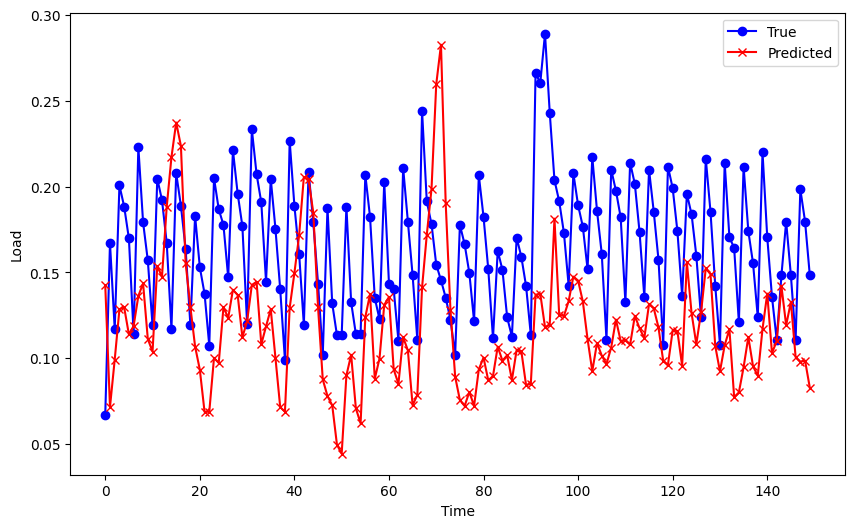

In [ ]:
import matplotlib.pyplot as plt

# Define the number of points to display
num_points = 150

# Ensure we only take the first 150 points
y_test_subset = y_test[:num_points]
predictions_subset = predictions[:num_points]

plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_subset)), y_test_subset, color='blue', marker='o', linestyle='-', label='True')
plt.plot(range(len(predictions_subset)), predictions_subset, color='red', marker='x', linestyle='-', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()